# Loan Default Prediction

## Importing Libraries

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline

#import libraries for model training
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from lightgbm import LGBMClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import cross_val_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, precision_recall_curve, precision_score, recall_score, f1_score, accuracy_score
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE


## Read file

In [65]:
path = 'C:/Users/mozulkifli/Downloads/mydocs/Project/Data_Source/'
file_name = 'Loan_default.csv'

In [66]:
df = pd.read_csv(path + file_name)
df.head()

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0


## Exploring Dataset

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255347 entries, 0 to 255346
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   LoanID          255347 non-null  object 
 1   Age             255347 non-null  int64  
 2   Income          255347 non-null  int64  
 3   LoanAmount      255347 non-null  int64  
 4   CreditScore     255347 non-null  int64  
 5   MonthsEmployed  255347 non-null  int64  
 6   NumCreditLines  255347 non-null  int64  
 7   InterestRate    255347 non-null  float64
 8   LoanTerm        255347 non-null  int64  
 9   DTIRatio        255347 non-null  float64
 10  Education       255347 non-null  object 
 11  EmploymentType  255347 non-null  object 
 12  MaritalStatus   255347 non-null  object 
 13  HasMortgage     255347 non-null  object 
 14  HasDependents   255347 non-null  object 
 15  LoanPurpose     255347 non-null  object 
 16  HasCoSigner     255347 non-null  object 
 17  Default   

In [68]:
df["Default"].value_counts()

Default
0    225694
1     29653
Name: count, dtype: int64

- 0 = non-defaulters
- 1 = defaulters

### Checking for missing values

In [69]:
df.isnull().sum()

LoanID            0
Age               0
Income            0
LoanAmount        0
CreditScore       0
MonthsEmployed    0
NumCreditLines    0
InterestRate      0
LoanTerm          0
DTIRatio          0
Education         0
EmploymentType    0
MaritalStatus     0
HasMortgage       0
HasDependents     0
LoanPurpose       0
HasCoSigner       0
Default           0
dtype: int64

Clean data no missing values

## Data Preprocessing

### Dropping unused columns


In [70]:
# make a list to for name of columns to drop
columns_to_drop = ['LoanID']

# drop the columns listed
df.drop(columns=columns_to_drop, inplace=True, axis=1)

# remove any rows with at least one NaN
df.dropna(inplace=True)

Removed the LoanID column as it will not help in the prediction

### Checking correlation among the features

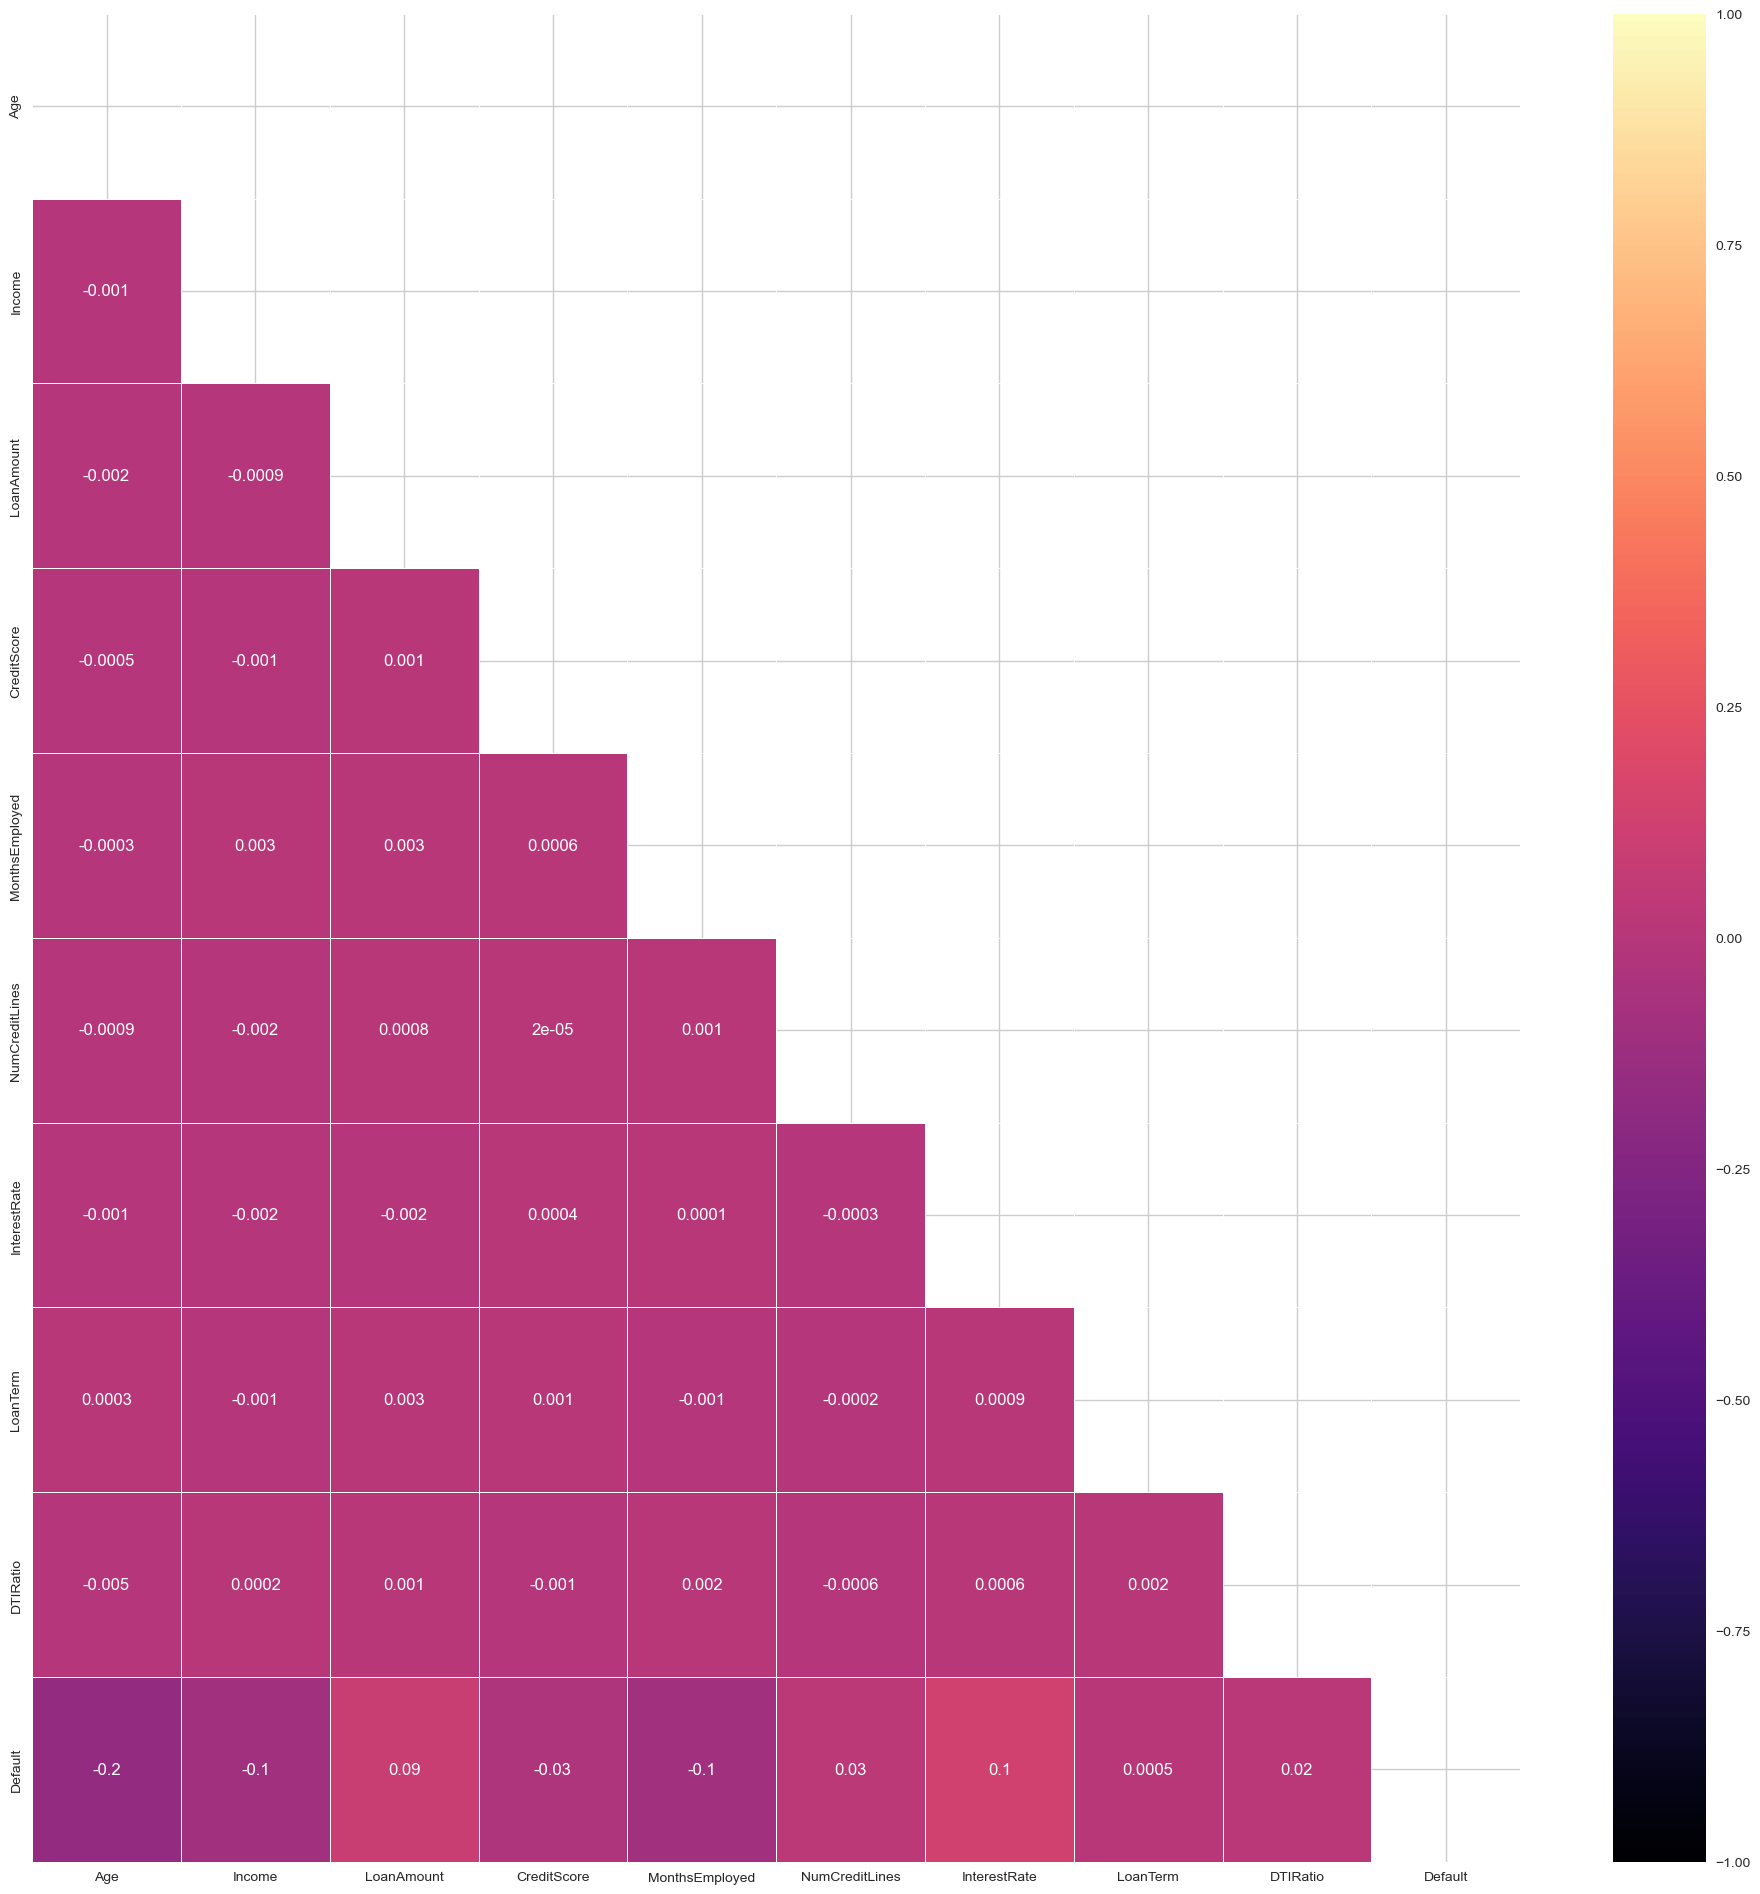

In [71]:
corr = df.select_dtypes(include=["number"]).corr()

mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(24,24))
sns.heatmap(corr, 
            mask=mask, 
            annot=True,  
            cmap="magma", 
            vmin = -1,
            vmax = 1, 
            fmt='.1g', 
            edgecolor='w', 
            linewidth=0.6)
plt.show()

In [72]:
# Compute correlation matrix for numeric columns
corr = df.select_dtypes(include=["number"]).corr()

# Set threshold for "high correlation"
threshold = 0.7

# Get pairs of features with correlation above threshold
high_corr = (
    corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))  # upper triangle only
    .stack()  # turn into long format
    .reset_index()
)

# Rename columns for clarity
high_corr.columns = ["Feature1", "Feature2", "Correlation"]

# Filter based on threshold
high_corr = high_corr[high_corr["Correlation"].abs() > threshold]

print(high_corr)


Empty DataFrame
Columns: [Feature1, Feature2, Correlation]
Index: []


The features have very low correlation with each other. So we will not require to drop the features due to high correlation.

### Descriptive Statistics

In [73]:
df.describe()

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Default
count,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000
mean,43.498306,82499.304597,127578.865512,574.264346,59.541976,2.501036,13.492773,36.025894,0.500212,0.116128
std,14.990258,38963.013729,70840.706142,158.903867,34.643376,1.117018,6.636443,16.969330,0.230917,0.320379
min,18.000000,15000.000000,5000.000000,300.000000,0.000000,1.000000,2.000000,12.000000,0.100000,0.000000
25%,31.000000,48825.500000,66156.000000,437.000000,30.000000,2.000000,7.770000,24.000000,0.300000,0.000000
50%,43.000000,82466.000000,127556.000000,574.000000,60.000000,2.000000,13.460000,36.000000,0.500000,0.000000
75%,56.000000,116219.000000,188985.000000,712.000000,90.000000,3.000000,19.250000,48.000000,0.700000,0.000000
max,69.000000,149999.000000,249999.000000,849.000000,119.000000,4.000000,25.000000,60.000000,0.900000,1.000000


### Data transformation

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255347 entries, 0 to 255346
Data columns (total 17 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Age             255347 non-null  int64  
 1   Income          255347 non-null  int64  
 2   LoanAmount      255347 non-null  int64  
 3   CreditScore     255347 non-null  int64  
 4   MonthsEmployed  255347 non-null  int64  
 5   NumCreditLines  255347 non-null  int64  
 6   InterestRate    255347 non-null  float64
 7   LoanTerm        255347 non-null  int64  
 8   DTIRatio        255347 non-null  float64
 9   Education       255347 non-null  object 
 10  EmploymentType  255347 non-null  object 
 11  MaritalStatus   255347 non-null  object 
 12  HasMortgage     255347 non-null  object 
 13  HasDependents   255347 non-null  object 
 14  LoanPurpose     255347 non-null  object 
 15  HasCoSigner     255347 non-null  object 
 16  Default         255347 non-null  int64  
dtypes: float64

In [75]:
df.head()

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0
4,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0


Categorical Features:
- Education
- EmploymentType
- MaritalStatus
- HasMortgage
- HasDependents
- LoanPurpose
- HasCoSigner

In [76]:
# List of categorical features
categorical_features = [
    "Education",
    "EmploymentType",
    "MaritalStatus",
    "HasMortgage",
    "HasDependents",
    "LoanPurpose",
    "HasCoSigner"
]

# Loop through each categorical feature and print unique values
for col in categorical_features:
    print(f"\n{col} unique values:")
    print(df[col].unique())


Education unique values:
["Bachelor's" "Master's" 'High School' 'PhD']

EmploymentType unique values:
['Full-time' 'Unemployed' 'Self-employed' 'Part-time']

MaritalStatus unique values:
['Divorced' 'Married' 'Single']

HasMortgage unique values:
['Yes' 'No']

HasDependents unique values:
['Yes' 'No']

LoanPurpose unique values:
['Other' 'Auto' 'Business' 'Home' 'Education']

HasCoSigner unique values:
['Yes' 'No']


Seperating categorical features from numerical

In [77]:
categorical_features = df.select_dtypes(exclude='number')
numerical_features = df.select_dtypes(exclude='object')

In [78]:
categorical_features.head()

,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner
0,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes
1,Master's,Full-time,Married,No,No,Other,Yes
2,Master's,Unemployed,Divorced,Yes,Yes,Auto,No
3,High School,Full-time,Married,No,No,Business,No
4,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No


In [79]:
numerical_features.head()

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Default
0,56,85994,50587,520,80,4,15.23,36,0.44,0
1,69,50432,124440,458,15,1,4.81,60,0.68,0
2,46,84208,129188,451,26,3,21.17,24,0.31,1
3,32,31713,44799,743,0,3,7.07,24,0.23,0
4,60,20437,9139,633,8,4,6.51,48,0.73,0


Final check for missing values

In [80]:
preprocess_data = df

#checking for any missing values
missing = preprocess_data.isnull().sum()
missing[missing>0]

Series([], dtype: int64)

No missing values

### Calculate WoE and IV

In [81]:
preprocess_data['Default'].value_counts(normalize=True)

Default
0    0.883872
1    0.116128
Name: proportion, dtype: float64

In [82]:
#function to calculate Weight of Evidence (WoE) and Information Value (IV)

def iv_woe(df, target, bins=10, show_woe=False):
    
    newDF,woeDF = pd.DataFrame(), pd.DataFrame()
    cols = df.columns
    
    #Run WoE and IV on all the independent variables
    for ivars in cols[~cols.isin([target])]:
        if (df[ivars].dtype.kind in 'bifc') and (len(np.unique(df[ivars]))>10):
            binned_x = pd.qcut(df[ivars], bins,  duplicates='drop')
            d0 = pd.DataFrame({'x': binned_x, 'y': df[target]})
        else:
            d0 = pd.DataFrame({'x': df[ivars], 'y': df[target]})
        d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']
        d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()
        d['Non-Events'] = d['N'] - d['Events']
        d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()
        d['WoE'] = np.log(d['% of Events']/d['% of Non-Events'])
        d['IV'] = d['WoE'] * (d['% of Events'] - d['% of Non-Events'])
        d.insert(loc=0, column='Variable', value=ivars)
        print("Information value of " + ivars + " is " + str(round(d['IV'].sum(),6)))
        temp =pd.DataFrame({"Variable" : [ivars], "IV" : [d['IV'].sum()]}, columns = ["Variable", "IV"])
        newDF=pd.concat([newDF,temp], axis=0)
        woeDF=pd.concat([woeDF,d], axis=0)

        if show_woe == True:
            print(d)
            
    return newDF, woeDF

iv, woe = iv_woe(preprocess_data, target='Default', bins=20)

Information value of Age is 0.289623
Information value of Income is 0.13226
Information value of LoanAmount is 0.074521
Information value of CreditScore is 0.012015
Information value of MonthsEmployed is 0.094633
Information value of NumCreditLines is 0.007902
Information value of InterestRate is 0.174679
Information value of LoanTerm is 2e-05
Information value of DTIRatio is 0.004493
Information value of Education is 0.008127
Information value of EmploymentType is 0.020633
Information value of MaritalStatus is 0.007784
Information value of HasMortgage is 0.005096
Information value of HasDependents is 0.011747
Information value of LoanPurpose is 0.005057
Information value of HasCoSigner is 0.014952


WOE

In [83]:
# function to calculate WoE of cat features

def woe_categorical(df, categorical_feature, good_bad_df):
    df = pd.concat([df[categorical_feature], good_bad_df], axis=1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    df = df.sort_values(['WoE'])
    df = df.reset_index(drop = True)
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df

In [84]:
# function to plot WoE
import numpy as np

def plot_by_woe(df_WoE, rotation_of_x_axis_labels = 0):
    x = np.array(df_WoE.iloc[:, 0].apply(str))
    y = df_WoE['WoE']
    plt.figure(figsize=(18, 12))
    plt.plot(x, y, marker = 'o', color = 'hotpink', linestyle = 'dashed', linewidth = 3, markersize = 18, markeredgecolor = 'cyan', markerfacecolor = 'black')
    plt.xlabel(df_WoE.columns[0])
    plt.ylabel('Weight of Evidence')
    plt.title(str('Weight of Evidence by ' + df_WoE.columns[0]))
    plt.xticks(rotation = rotation_of_x_axis_labels) 
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

In [85]:
categorical_features.value_counts()

Education    EmploymentType  MaritalStatus  HasMortgage  HasDependents  LoanPurpose  HasCoSigner
Bachelor's   Unemployed      Married        Yes          No             Other        Yes            172
             Part-time       Single         Yes          No             Education    No             171
             Full-time       Single         No           No             Other        No             170
PhD          Part-time       Married        Yes          Yes            Auto         No             170
High School  Unemployed      Single         No           Yes            Home         No             169
                                                                                                   ... 
PhD          Full-time       Divorced       No           Yes            Education    No              98
Master's     Self-employed   Single         Yes          No             Auto         Yes             98
PhD          Self-employed   Married        No           Yes           

In [86]:
# labelling the target and feature table
X = df.drop('Default', axis = 1)
y = df['Default']

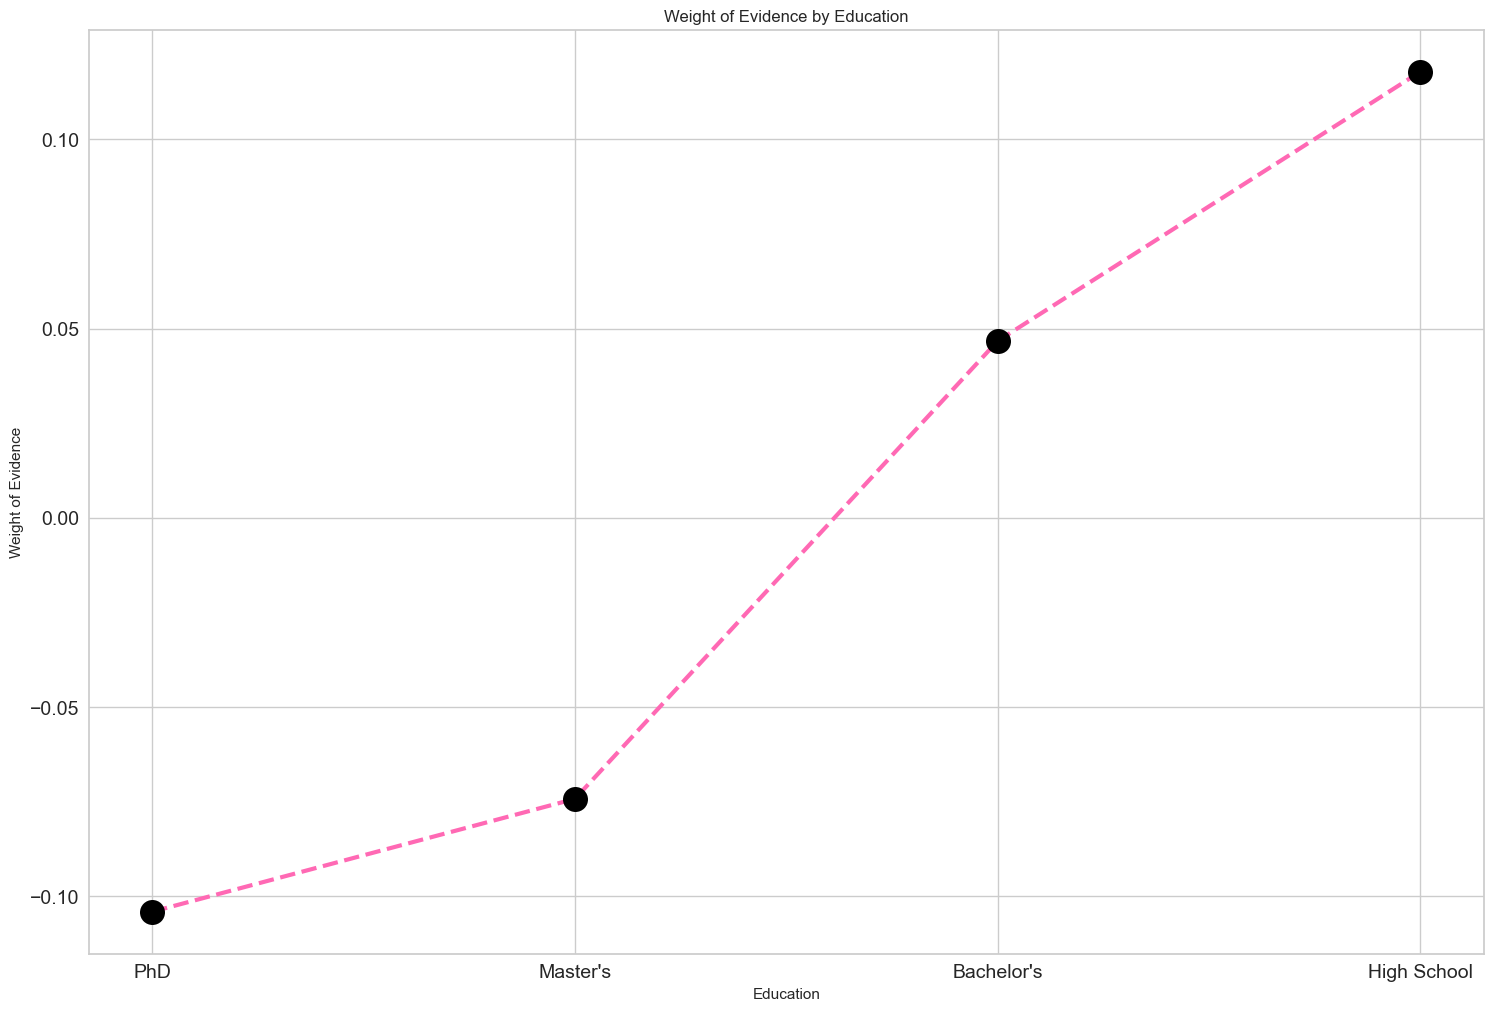

In [87]:
# 1. Analyzing Education variable
df_education = woe_categorical(X, 'Education', y)
plot_by_woe(df_education)

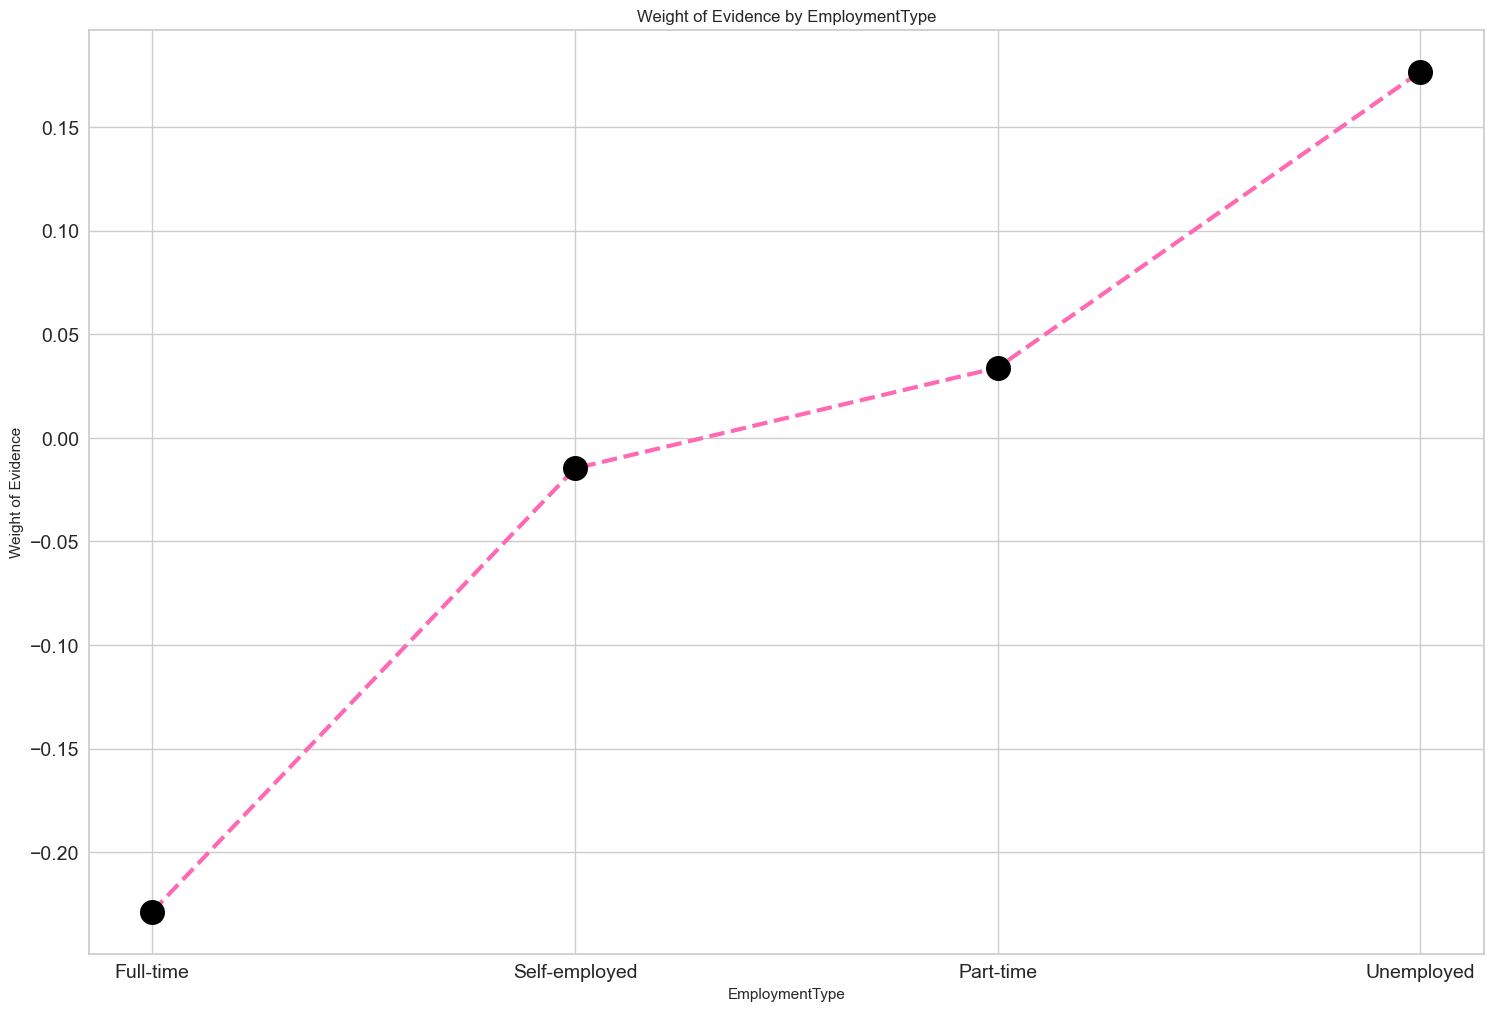

In [88]:
# 2. Analyzing EducaEmploymentTypetion variable
df_employmenttype = woe_categorical(X, 'EmploymentType', y)
plot_by_woe(df_employmenttype)

### Checking class imbalance

In [89]:
df.head()

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0
4,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0


In [90]:
df['Default'].value_counts(normalize=True)

Default
0    0.883872
1    0.116128
Name: proportion, dtype: float64

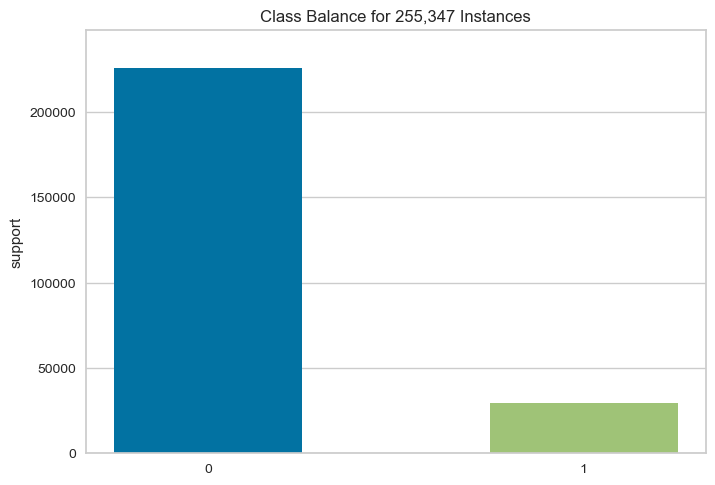

<Axes: title={'center': 'Class Balance for 255,347 Instances'}, ylabel='support'>

In [91]:
#check if class labels are balanced

from yellowbrick.target import ClassBalance
X= df.drop(columns='Default', axis=1)
y = df['Default']
visualizer = ClassBalance()
visualizer.fit(y)
visualizer.show()

In [92]:
categorical_features.head()

,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner
0,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes
1,Master's,Full-time,Married,No,No,Other,Yes
2,Master's,Unemployed,Divorced,Yes,Yes,Auto,No
3,High School,Full-time,Married,No,No,Business,No
4,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No


In [93]:
numerical_features.head()

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Default
0,56,85994,50587,520,80,4,15.23,36,0.44,0
1,69,50432,124440,458,15,1,4.81,60,0.68,0
2,46,84208,129188,451,26,3,21.17,24,0.31,1
3,32,31713,44799,743,0,3,7.07,24,0.23,0
4,60,20437,9139,633,8,4,6.51,48,0.73,0


### Split train-test

In [94]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

### Modeling

In [95]:
# Results list
results = []

# Evaluation helper
def evaluate_model(name, pipeline):
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]

    results.append({
        "Model": name,
        "AUC": roc_auc_score(y_test, y_proba),
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred)
    })

#### Logistic Regression
- Include one hot encoding
- Scaling
- Balance using SMOTE

In [96]:
#drop Default from numerical features table
numerical_features = numerical_features.drop(columns='Default', axis=1)

# Getting the column name only
categorical_features_column_name = categorical_features.columns.tolist()
numerical_features_column_name = numerical_features.columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_features_column_name),
        ("num", StandardScaler(), numerical_features_column_name)
    ]
)

logreg_pipeline = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("oversample", RandomOverSampler(random_state=42)),
    ("classifier", LogisticRegression(max_iter=500, class_weight="balanced"))
])

evaluate_model("Logistic Regression", logreg_pipeline)

#### 

#### Random Forest

In [97]:
rf_pipeline = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("oversample", RandomOverSampler(random_state=42)),
    ("classifier", RandomForestClassifier(n_estimators=200, random_state=42, class_weight="balanced"))
])

evaluate_model("Random Forest", rf_pipeline)

#### XGBoost

In [98]:
xgb_pipeline = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("oversample", RandomOverSampler(random_state=42)),
    ("classifier", XGBClassifier(
        use_label_encoder=False,
        eval_metric="logloss",
        random_state=42,
        scale_pos_weight=1
    ))
])

evaluate_model("XGBoost", xgb_pipeline)

#### LightGBM

In [99]:
lgbm_pipeline = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("oversample", RandomOverSampler(random_state=42)),
    ("classifier", LGBMClassifier(random_state=42, class_weight="balanced"))
])

evaluate_model("LightGBM", lgbm_pipeline)

[LightGBM] [Info] Number of positive: 180555, number of negative: 180555
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004810 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1316
[LightGBM] [Info] Number of data points in the train set: 361110, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


#### CatBoost

In [100]:
cat_pipeline = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("oversample", RandomOverSampler(random_state=42)),
    ("classifier", CatBoostClassifier(
        iterations=200,
        learning_rate=0.1,
        depth=6,
        random_seed=42,
        verbose=0,
        class_weights=[1, 1]  # you can adjust if imbalance is severe
    ))
])

evaluate_model("CatBoost", cat_pipeline)

#### Comparing model performance

In [101]:
results_df = pd.DataFrame(results).sort_values(by="AUC", ascending=False)
print(results_df)


                 Model       AUC  Accuracy  Precision    Recall        F1
4             CatBoost  0.758836  0.697650   0.229952  0.682684  0.344025
3             LightGBM  0.756554  0.696554   0.228732  0.679987  0.342316
0  Logistic Regression  0.753111  0.676522   0.219734  0.699882  0.334461
1        Random Forest  0.744298  0.885393   0.560372  0.061035  0.110081
2              XGBoost  0.740390  0.716272   0.232247  0.625864  0.338779
